## 코로나 바이러스

### 목표

1. 오픈데이터를 활용하여 코로나 바이러스 확진자들의 인구 통계를 확인합니다.
2. 세계 통계 데이터는 질변관리본부에서 업데이트 되는 데이터를 크롤링하여 동적으로 가져 옵니다.
3. 기존 데이터와 크롤링 데이터 그리고 외부 데이터와 병합하여 종합적인 인사이트 결과를 도출합니다.

데이터 디렉토리 지정

In [1]:
DATA_DIR = 'covid19-data'

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


warnings.filterwarnings('ignore')
%matplotlib inline

In [137]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

### 한글, 나눔 폰트 지정

In [3]:
from matplotlib import font_manager, rc

font_fname = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=font_fname).get_name()

rc('font', family=font_name)
print(font_name)

NanumGothic


In [4]:
os.listdir(DATA_DIR)

['SeoulFloating.csv',
 'Weather.csv',
 'TimeProvince.csv',
 'Time.csv',
 'Region.csv',
 'Policy.csv',
 'PatientRoute.csv',
 'PatientInfo.csv',
 'SearchTrend.csv',
 'TimeAge.csv',
 'TimeGender.csv',
 'Case.csv']

## 환자 데이터(patient_info) 기본 정보

In [5]:
patient_info = pd.read_csv(os.path.join(DATA_DIR, 'PatientInfo.csv'))

In [6]:
patient_info.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [7]:
patient_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5165 entries, 0 to 5164
Data columns (total 14 columns):
patient_id            5165 non-null int64
sex                   4043 non-null object
age                   3785 non-null object
country               5165 non-null object
province              5165 non-null object
city                  5071 non-null object
infection_case        4246 non-null object
infected_by           1346 non-null object
contact_number        791 non-null object
symptom_onset_date    690 non-null object
confirmed_date        5162 non-null object
released_date         1587 non-null object
deceased_date         66 non-null object
state                 5165 non-null object
dtypes: int64(1), object(13)
memory usage: 565.0+ KB


In [8]:
patient_info.isnull().sum()

patient_id               0
sex                   1122
age                   1380
country                  0
province                 0
city                    94
infection_case         919
infected_by           3819
contact_number        4374
symptom_onset_date    4475
confirmed_date           3
released_date         3578
deceased_date         5099
state                    0
dtype: int64

datetime으로 형변환

In [9]:
patient_info['confirmed_date'] = pd.to_datetime(patient_info['confirmed_date'])
patient_info['released_date'] = pd.to_datetime(patient_info['released_date'])

## 본 데이터는 1월 20일 ~ 6월 30일까지의 데이터

In [10]:
patient_info['confirmed_date'].sort_values().head()

1644   2020-01-20
0      2020-01-23
2213   2020-01-26
2214   2020-01-27
2      2020-01-30
Name: confirmed_date, dtype: datetime64[ns]

In [11]:
patient_info['confirmed_date'].sort_values().tail()

1985   2020-06-30
3706   2020-06-30
4730          NaT
4731          NaT
4732          NaT
Name: confirmed_date, dtype: datetime64[ns]

## 확진자 증감 현황

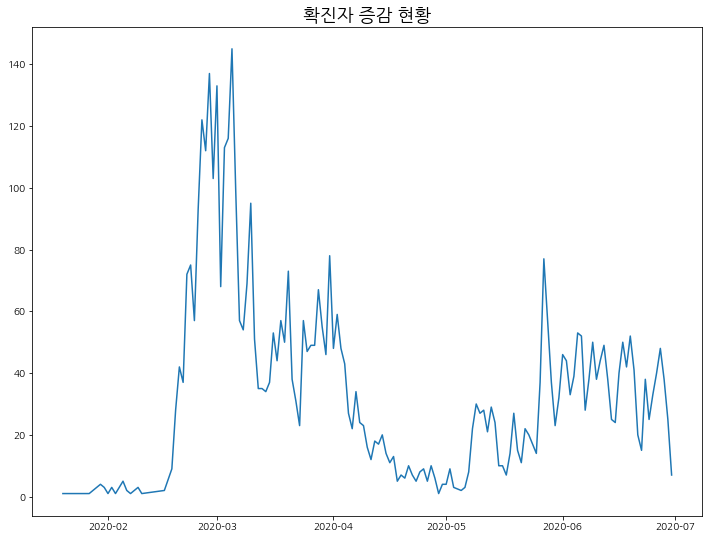

In [12]:
plt.figure(figsize=(12, 9))
plt.title('확진자 증감 현황', fontsize=18)
plt.plot(patient_info.groupby('confirmed_date')['patient_id'].count())
plt.show()

In [13]:
patient_by_date = patient_info.groupby('confirmed_date')['patient_id'].count().reset_index()

## 확진자 누적추이

In [14]:
patient_by_date['patient_id'].cumsum().head()

0    1
1    2
2    3
3    4
4    8
Name: patient_id, dtype: int64

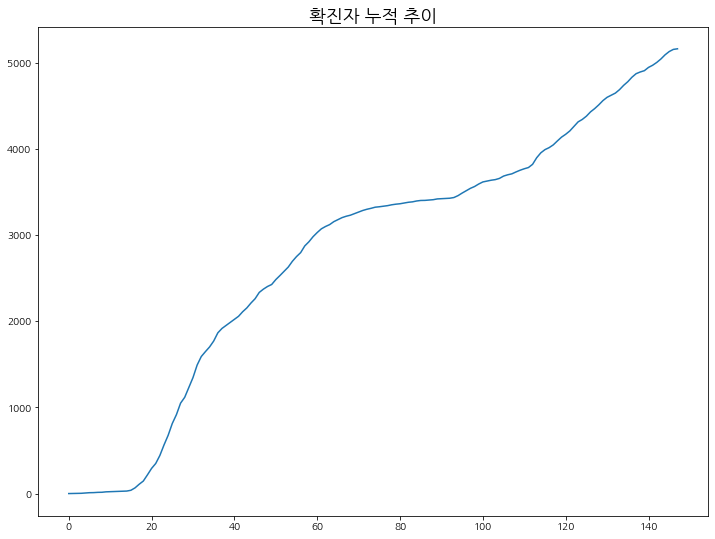

In [15]:
plt.figure(figsize=(12, 9))
plt.title('확진자 누적 추이', fontsize=18)
plt.plot(patient_by_date['patient_id'].cumsum())
plt.show()

## 확진자 별 접촉자수

In [16]:
patient_info['contact_number'] = patient_info['contact_number'].str.replace('-', '0')
patient_info['contact_number'].fillna('0', inplace=True)

In [17]:
patient_info['contact_number'] = pd.to_numeric(patient_info['contact_number'])

값이 잘못 기입되어 있는 것을 확인할 수 있습니다. 

`patient_info`의 아이디 값이 `contact_number`에 잘못 기입되어 있으므로, 0으로 변환합니다.

In [18]:
patient_info['contact_number'].sort_values(ascending=False).head()

5110    6100000099
5109    6100000098
818     1000000796
1463          1160
1312          1091
Name: contact_number, dtype: int64

In [19]:
patient_info.loc[[818, 5109, 5110]]

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
818,1000000819,NaN,NaN,Korea,Seoul,Eunpyeong-gu,NaN,NaN,1000000796,NaN,2020-05-27,NaT,NaN,released
5109,6100000097,female,60s,Korea,Gyeongsangnam-do,Jinju-si,etc,NaN,6100000098,2020-03-26,2020-03-31,NaT,NaN,released
5110,6100000098,male,60s,Korea,Gyeongsangnam-do,Jinju-si,etc,6100000097,6100000099,2020-03-28,2020-03-31,NaT,NaN,released


In [20]:
patient_info.loc[[818, 5109, 5110], 'contact_number'] = 0

In [21]:
patient_info.loc[[818, 5109, 5110]]

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
818,1000000819,NaN,NaN,Korea,Seoul,Eunpyeong-gu,NaN,NaN,0,NaN,2020-05-27,NaT,NaN,released
5109,6100000097,female,60s,Korea,Gyeongsangnam-do,Jinju-si,etc,NaN,0,2020-03-26,2020-03-31,NaT,NaN,released
5110,6100000098,male,60s,Korea,Gyeongsangnam-do,Jinju-si,etc,6100000097,0,2020-03-28,2020-03-31,NaT,NaN,released


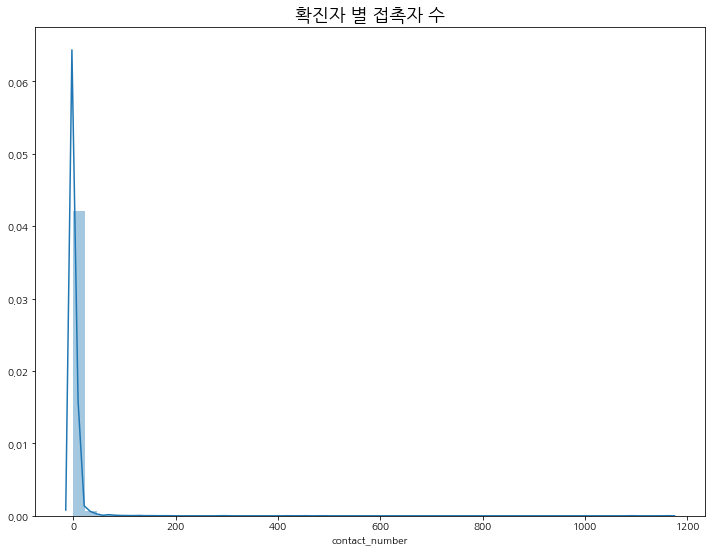

In [22]:
plt.figure(figsize=(12, 9))
sns.distplot(patient_info['contact_number'])
plt.title('확진자 별 접촉자 수', fontsize=18)
plt.show()

## 감염 경로에 따른 확진자 수

In [23]:
patient_info.groupby('infection_case')['patient_id'].count().sort_values(ascending=False)

infection_case
contact with patient                             1610
overseas inflow                                   840
etc                                               703
Itaewon Clubs                                     162
Richway                                           128
Guro-gu Call Center                               112
Shincheonji Church                                107
Coupang Logistics Center                           80
Yangcheon Table Tennis Club                        44
Day Care Center                                    43
SMR Newly Planted Churches Group                   36
Onchun Church                                      33
Bonghwa Pureun Nursing Home                        31
gym facility in Cheonan                            30
Ministry of Oceans and Fisheries                   28
Wangsung Church                                    24
Cheongdo Daenam Hospital                           21
Dongan Church                                      17
Eunpyeong St.

In [24]:
df = patient_info.groupby('infection_case')['patient_id'].count().sort_values(ascending=False)

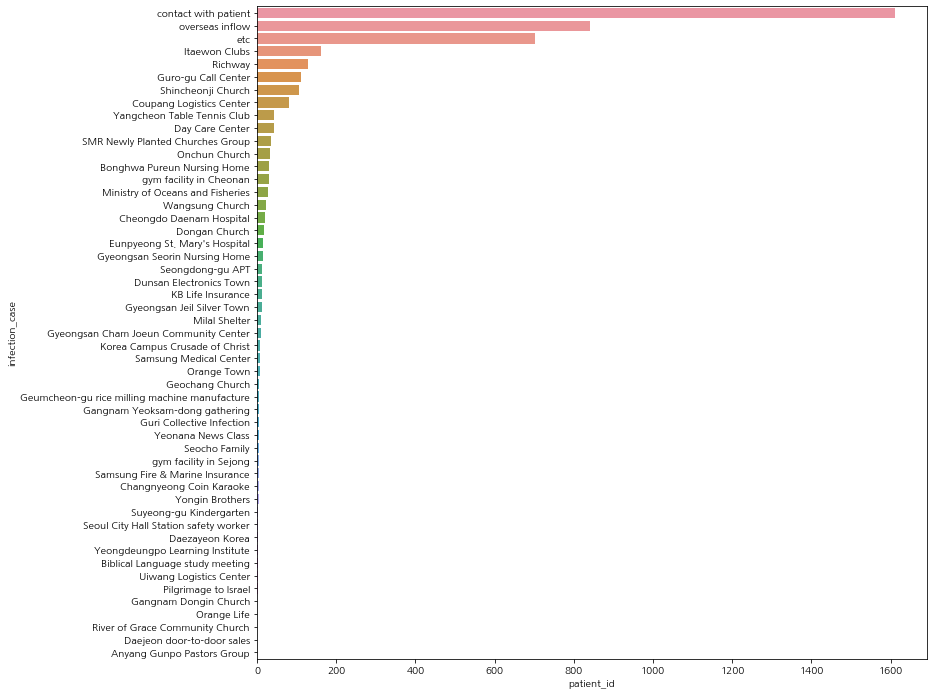

In [25]:
plt.figure(figsize=(12, 12))
sns.barplot(x=df, y=df.index)
plt.show()

## 성별 확진자 수

Text(0.5, 1.0, '성별 확진자 수')

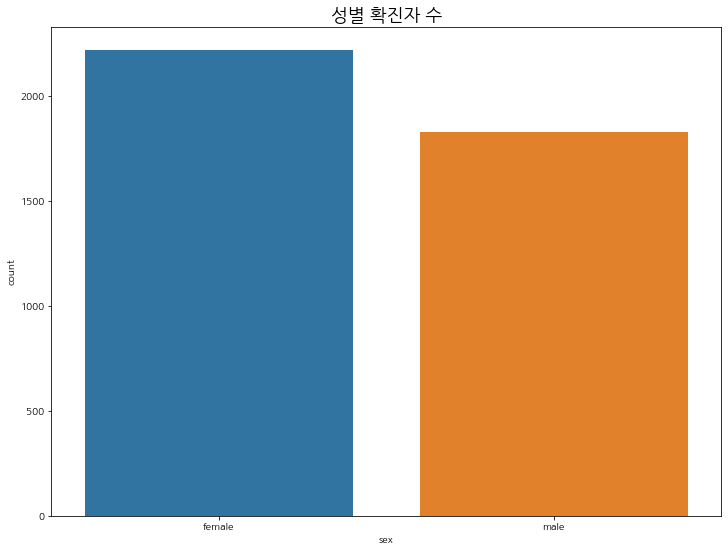

In [26]:
plt.figure(figsize=(12, 9))
sns.countplot(x='sex', data=patient_info, order=patient_info['sex'].value_counts().index)
plt.title('성별 확진자 수', fontsize=18)

## 연령별 확진자 수

Text(0.5, 1.0, '연령별 확진자 수')

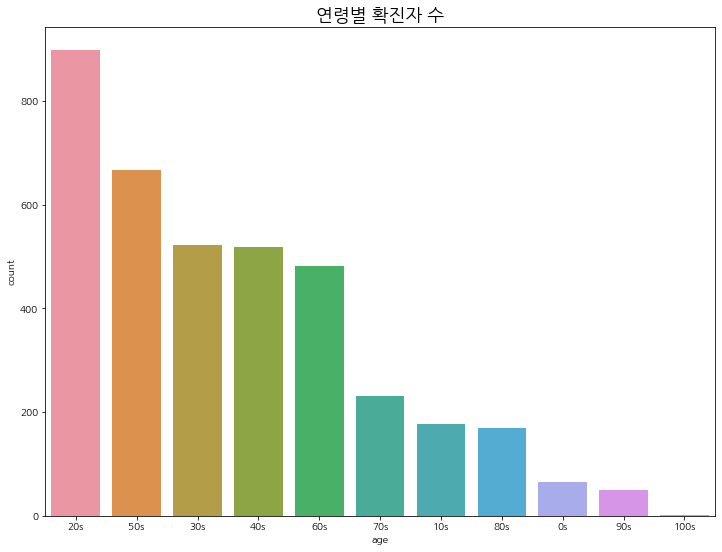

In [27]:
plt.figure(figsize=(12, 9))
sns.countplot(x='age', data=patient_info, order=patient_info['age'].value_counts().index)
plt.title('연령별 확진자 수', fontsize=18)

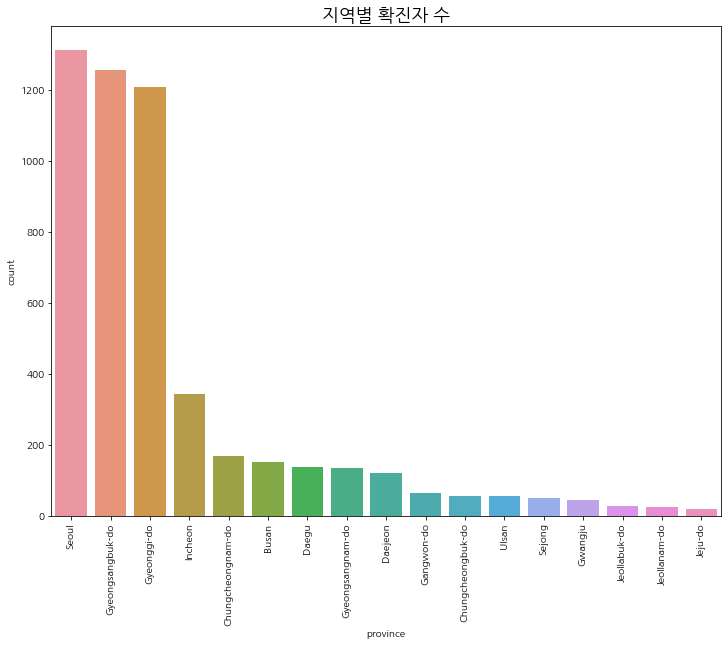

In [28]:
plt.figure(figsize=(12, 9))
sns.countplot(x='province', data=patient_info, order=patient_info['province'].value_counts().index)
plt.title('지역별 확진자 수', fontsize=18)
plt.xticks(rotation=90)
plt.show()

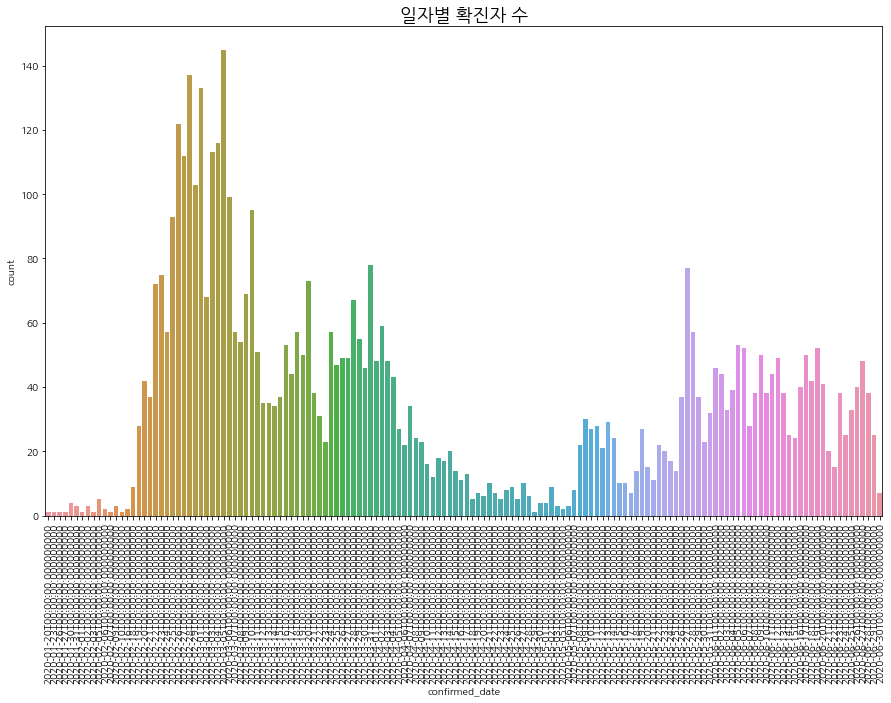

In [29]:
plt.figure(figsize=(15, 9))
sns.countplot(x='confirmed_date', data=patient_info)
plt.title('일자별 확진자 수', fontsize=18)
plt.xticks(rotation=90)
plt.show()

## 2. 세계 코로나 발생 현황 (데이터 크롤링)

세계 코로나 발생 현황은 질병본부 웹사이트에서 매일 업데이트 됩니다.

[웹사이트 보기](http://ncov.mohw.go.kr/bdBoardList_Real.do?brdId=1&brdGubun=14&ncvContSeq=&contSeq=&board_id=&gubun=)

In [30]:
import requests
from bs4 import BeautifulSoup

In [31]:
url = 'http://ncov.mohw.go.kr/bdBoardList_Real.do?brdId=1&brdGubun=14&ncvContSeq=&contSeq=&board_id=&gubun='

In [32]:
req=requests.get(url)
html=req.text
soup=BeautifulSoup(html,'html.parser')

In [33]:
soup


<!DOCTYPE HTML>

<html lang="ko">
<head>
<title>코로나바이러스감염증-19 &gt; 발생동향 &gt; 국외 발생 현황</title>
<meta content="코로나바이러스감염증-19,발생동향, 국외 발생 현황,전체 국가 발생 현황,주요 발생 국가 주간 동향" name="description"/>
<meta content="코로나바이러스감염증-19,발생동향, 국외 발생 현황,전체 국가 발생 현황,주요 발생 국가 주간 동향" property="og:description"/>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width, initial-scale=1, user-scalable=yes" name="viewport"/>
<meta content="보건복지부, 코로나바이러스감염증-19(COVID-19), 질병관리본부" name="author"/>
<meta content="코로나바이러스감염증-19(COVID-19), 코로나바이러스감염증-19, 코로나바이러스, 보건복지부" name="keywords"/>
<meta content="보건복지부" name="copyright"/>
<meta content="http://ncov.mohw.go.kr/" property="og:url"/>
<meta content="website" property="og:type"/>
<meta content="코로나바이러스감염증-19(COVID-19)" property="og:site_name"/>
<meta content="ko" property="og:locale"/>
<meta content="코로나바이러스감염증-19(COVID-19)" property="og:title"/>
<meta content="http://ncov.mohw.go.kr/static/image/header/homeimg.pn

In [34]:
table = soup.findAll('table',{"class":"num"})[0]

In [35]:
import re

In [36]:
global_data = []

tr = table.findAll(['tr'])
for cell in tr:
    td = cell.find_all('td')
    if len(td) > 0:
        if td[0] is not None:
            country = td[0].text.strip()
        
        if len(td) > 1:
            count = td[1].text
            # 숫자만 추출
            count = re.sub(r'[^0-9\(\)]', '', count)
            # 사망자 추출
            result = re.search(r'\(\d+\)', count)
            if result:
                died = result.group()
            else:
                died = '(0)'
            confirmed = count.split('(')[0]
        print('국가: %s\t확진자: %s\t사망자: %s' % (country, confirmed, died[1:-1]))
        global_data.append({'국가': country, '확진자': confirmed, '사망자': died[1:-1]})

국가: 중국	확진자: 83830	사망자: 4634
국가: 홍콩	확진자: 2505	사망자: 18
국가: 대만	확진자: 458	사망자: 7
국가: 마카오	확진자: 46	사망자: 0
국가: 일본	확진자: 29382	사망자: 996
국가: 싱가포르	확진자: 49888	사망자: 27
국가: 태국	확진자: 3282	사망자: 58
국가: 말레이시아	확진자: 8861	사망자: 123
국가: 베트남	확진자: 415	사망자: 0
국가: 인도	확진자: 1336861	사망자: 31358
국가: 필리핀	확진자: 76444	사망자: 1879
국가: 캄보디아	확진자: 202	사망자: 0
국가: 네팔	확진자: 18374	사망자: 44
국가: 스리랑카	확진자: 2764	사망자: 11
국가: 아프가니스탄	확진자: 36036	사망자: 1246
국가: 파키스탄	확진자: 271887	사망자: 5787
국가: 인도네시아	확진자: 95418	사망자: 4665
국가: 부탄	확진자: 92	사망자: 0
국가: 몰디브	확진자: 3175	사망자: 15
국가: 방글라데시	확진자: 218658	사망자: 2836
국가: 브루나이	확진자: 141	사망자: 2
국가: 몽골	확진자: 288	사망자: 0
국가: 카자흐스탄	확진자: 80226	사망자: 585
국가: 우즈베키스탄	확진자: 19653	사망자: 104
국가: 키르기스스탄	확진자: 31247	사망자: 1249
국가: 동티모르	확진자: 24	사망자: 0
국가: 미얀마	확진자: 346	사망자: 6
국가: 라오스	확진자: 20	사망자: 0
국가: 타지키스탄	확진자: 7104	사망자: 58
국가: 이란	확진자: 288839	사망자: 15484
국가: 바레인	확진자: 38458	사망자: 137
국가: 이집트	확진자: 91072	사망자: 4518
국가: 이라크	확진자: 107573	사망자: 4284
국가: 요르단	확진자: 1310	사망자: 11
국가: 쿠웨이트	확진자: 63309	사망자: 429
국가: 레바논	확진자: 3407	사망자: 46
국가: 리비아	확진자: 2425	

In [37]:
df = pd.DataFrame(global_data)

In [38]:
df.head(20)

,국가,사망자,확진자
0,중국,4634,83830
1,홍콩,18,2505
2,대만,7,458
3,마카오,0,46
4,일본,996,29382
5,싱가포르,27,49888
6,태국,58,3282
7,말레이시아,123,8861
8,베트남,0,415
9,인도,31358,1336861


In [39]:
df[['사망자', '확진자']] = df[['사망자', '확진자']].astype(int)

### 사망자 별 정렬

In [40]:
df.sort_values(by='사망자', ascending=False).head(10)

,국가,사망자,확진자
47,미국,146391,4174437
70,브라질,86449,2394513
85,영국,45738,298681
49,멕시코,43374,385036
82,이탈리아,35102,245864
9,인도,31358,1336861
84,프랑스,30192,180528
86,스페인,28432,272421
71,페루,17843,375961
29,이란,15484,288839


### 확진자 별 정렬

In [41]:
df.sort_values(by='확진자', ascending=False).head(10)

,국가,사망자,확진자
47,미국,146391,4174437
70,브라질,86449,2394513
9,인도,31358,1336861
130,러시아,13192,806720
138,남아프리카공화국,6343,421996
49,멕시코,43374,385036
71,페루,17843,375961
73,칠레,9020,343592
85,영국,45738,298681
29,이란,15484,288839


### 확진자 - 사망율

In [42]:
df['확진자사망율'] = df['사망자'] / df['확진자']

확진자 사망율 정렬 (상위 10개 국가)

In [43]:
df.sort_values(by='확진자사망율', ascending=False).head(10)

,국가,사망자,확진자,확진자사망율
46,예멘,470,1678,0.280095
84,프랑스,30192,180528,0.167243
85,영국,45738,298681,0.153133
92,벨기에,9817,65106,0.150785
82,이탈리아,35102,245864,0.142770
116,헝가리,596,4424,0.134720
100,네덜란드,6139,52595,0.116722
49,멕시코,43374,385036,0.112649
86,스페인,28432,272421,0.104368
164,차드,75,915,0.081967


확진자 사망율 정렬 (하위 10개 국가)

In [44]:
df.sort_values(by='확진자사망율', ascending=True).head(10)

,국가,사망자,확진자,확진자사망율
69,세인트키츠네비스,0,17,0.0
27,라오스,0,20,0.0
25,동티모르,0,24,0.0
133,피지,0,27,0.0
21,몽골,0,288,0.0
17,부탄,0,92,0.0
171,에리트레아,0,261,0.0
156,세이쉘,0,107,0.0
11,캄보디아,0,202,0.0
68,도미니카연방,0,18,0.0


## 검색 트렌드

In [45]:
search_trend = pd.read_csv(os.path.join(DATA_DIR, 'SearchTrend.csv'))

In [46]:
search_trend.head()

,date,cold,flu,pneumonia,coronavirus
0,2016-01-01,0.11663,0.05590,0.15726,0.00736
1,2016-01-02,0.13372,0.17135,0.20826,0.00890
2,2016-01-03,0.14917,0.22317,0.19326,0.00845
3,2016-01-04,0.17463,0.18626,0.29008,0.01145
4,2016-01-05,0.17226,0.15072,0.24562,0.01381


In [47]:
search_trend['date'] = pd.to_datetime(search_trend['date'])

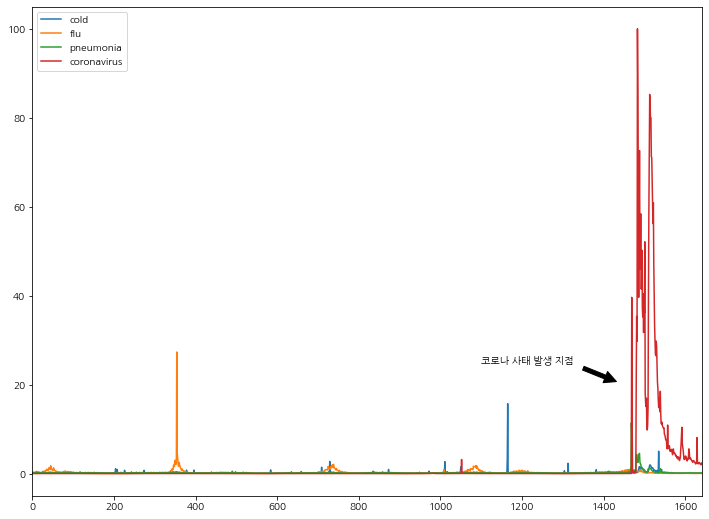

In [62]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
search_trend.iloc[:, 1:].plot(use_index=False, ax=ax)
# annotate 설정
plt.annotate('코로나 사태 발생 지점', xy=(1450, 20), xytext=(1100, 25), arrowprops=dict(facecolor='black', shrink=0.15))
plt.show()

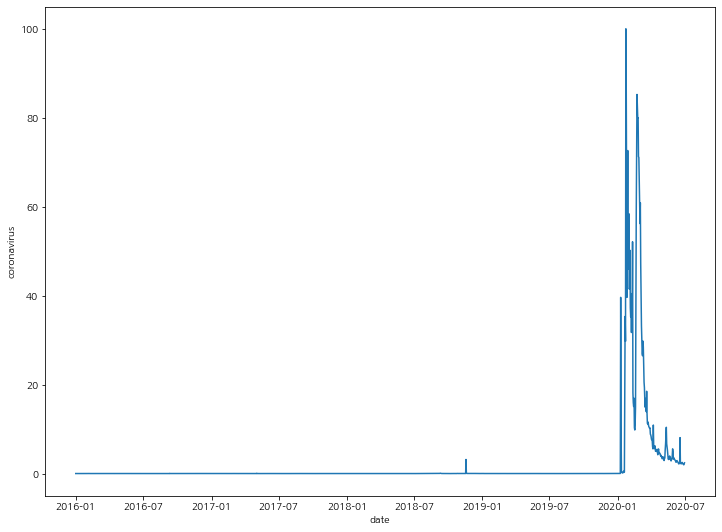

In [64]:
plt.figure(figsize=(12, 9))
sns.lineplot(x='date', y='coronavirus', data=search_trend)
plt.show()

### 2019년 12월 1일부터의 검색 트렌드 변화량

In [50]:
df_search = search_trend.loc[search_trend['date'] > '2019-12-01']

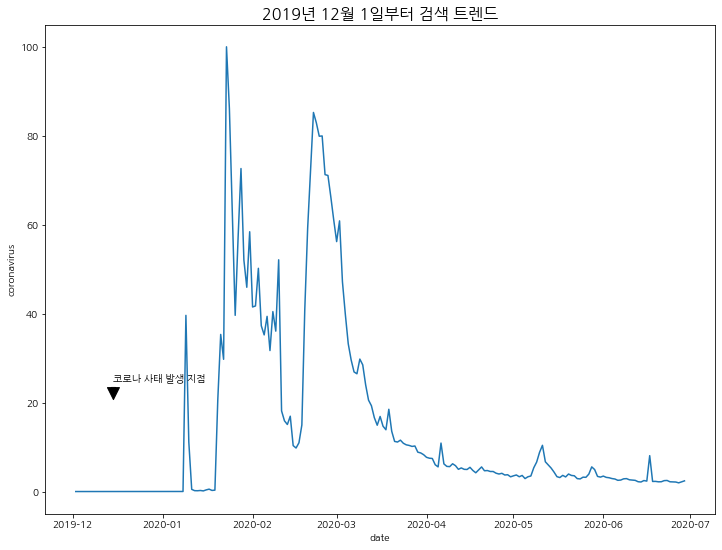

In [67]:
plt.figure(figsize=(12, 9))
sns.lineplot(x='date', y='coronavirus', data=df_search)
plt.title('2019년 12월 1일부터 검색 트렌드', fontsize=16)
plt.annotate('코로나 사태 발생 지점', xy=('2019-12-15', 20), xytext=('2019-12-15', 25), arrowprops=dict(facecolor='black', shrink=0.15))
plt.show()

## 외부데이터 받아오기 (KT 코로나바이러스)

In [68]:
import requests

import os
import os.path as pth

from multiprocessing import Pool
from functools import partial

from tqdm.notebook import tqdm

import zipfile

In [69]:
def download_file_from_google_drive(id_, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()
    response = session.get(URL, params = { 'id' : id_ }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id_, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
        
    basename = response.headers['Content-Disposition'].split(';')[1].split('filename=')[1].replace('\"', '')
    full_dst_filenname = pth.join(destination, basename)
    save_response_content(response, full_dst_filenname)
    return full_dst_filenname

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [70]:
file_id_list = [
    '1emS3CMUyd4EGLL6BGVzIAzjIYy6EO0QJ',
]

In [83]:
destination = 'kt-covid19' ### YOUR_DOWNLOAD_PATH

In [74]:
os.makedirs(destination, exist_ok=True)

filename_list = []

# ### Use single process
# for file_id in file_id_list:
#     filename = download_file_from_google_drive(id_=file_id, destination=destination)
#     print('{} is done!'.format(filename))
#     filename_list.append(filename)

### If you want to download more faster
download_func = partial(download_file_from_google_drive, destination=destination)
with Pool(4) as pool:
    for i, filename in tqdm(enumerate(pool.imap_unordered(download_func, file_id_list)), total=len(file_id_list)):
        print('{} is done!'.format(filename))
        filename_list.append(filename)

kt-covid19/KT_data_20200717.zip is done!



In [75]:
zip_filename_list = [filename for filename in filename_list if filename.endswith('.zip')]
    
for zip_filename in tqdm(zip_filename_list):
    with zipfile.ZipFile(zip_filename) as target_zip:
        dest_path = pth.splitext(zip_filename)[0]
        os.makedirs(dest_path, exist_ok=True)
        target_zip.extractall(dest_path)
        print('{} is done!'.format(dest_path))

kt-covid19/KT_data_20200717 is done!



In [80]:
os.listdir(destination)

['KT_data_20200717.zip', 'KT_data_20200717']

In [88]:
base_files = os.listdir(os.path.join(destination,'KT_data_20200717'))

In [89]:
base_files

['adstrd_master.csv',
 'card_20200717.csv',
 'COVID_19',
 'COVID_eng_kor_table.xlsx',
 'delivery.csv',
 'fpopl.csv',
 'index.csv']

In [90]:
base_files_path = [os.path.join(destination,'KT_data_20200717', x) for x in base_files]
base_files_path

['kt-covid19/KT_data_20200717/adstrd_master.csv',
 'kt-covid19/KT_data_20200717/card_20200717.csv',
 'kt-covid19/KT_data_20200717/COVID_19',
 'kt-covid19/KT_data_20200717/COVID_eng_kor_table.xlsx',
 'kt-covid19/KT_data_20200717/delivery.csv',
 'kt-covid19/KT_data_20200717/fpopl.csv',
 'kt-covid19/KT_data_20200717/index.csv']

## 코로나 펜데믹 이후 소비성향 분석

In [93]:
card = pd.read_csv(base_files_path[1])

상위 20개 소비

In [99]:
card.groupby('adstrd_nm')['mrhst_induty_cl_nm'].count().sort_values(ascending=False).head(20)

adstrd_nm
신사동            23214
종로1.2.3.4가동    20568
역삼1동           20366
서교동            17368
영등포동           17222
여의동            16617
명동             16511
압구정동           16314
가산동            15982
논현2동           15980
논현1동           15807
서초3동           15698
한강로동           15267
삼성1동           15265
대치2동           15196
구로3동           14898
청담동            14865
신촌동            14418
천호2동           14273
문정2동           14271
Name: mrhst_induty_cl_nm, dtype: int64

In [106]:
card.head()

,receipt_dttm,adstrd_code,adstrd_nm,mrhst_induty_cl_code,mrhst_induty_cl_nm,selng_cascnt,salamt
0,20200104,1174066000,성내3동,7041,약국,463,5843230
1,20200104,1174066000,성내3동,7022,치과의원,33,7835550
2,20200104,1174066000,성내3동,7021,한의원,53,4589800
3,20200104,1174066000,성내3동,7020,의원,339,9267240
4,20200104,1174066000,성내3동,6110,자동차정비,19,4441000


In [147]:
list(card['adstrd_nm'].value_counts().keys())[:20]

['신사동',
 '종로1.2.3.4가동',
 '역삼1동',
 '서교동',
 '영등포동',
 '여의동',
 '명동',
 '압구정동',
 '가산동',
 '논현2동',
 '논현1동',
 '서초3동',
 '한강로동',
 '삼성1동',
 '대치2동',
 '구로3동',
 '청담동',
 '신촌동',
 '천호2동',
 '문정2동']

In [124]:
location = '성내3동'

In [139]:
def plot_consume_patthern(location):
    x = card.loc[card['adstrd_nm'] == location, 'mrhst_induty_cl_nm'].value_counts().reset_index().head(20)
    plt.figure(figsize=(10, 15))
    sns.barplot(y='index', x='mrhst_induty_cl_nm', data=x, palette='coolwarm_r')
    plt.title('{} 소비카테고리 상위 TOP 20'.format(location), fontsize=16)
    plt.show()

    x = card.loc[card['adstrd_nm'] == location, 'mrhst_induty_cl_nm'].value_counts().reset_index().sort_values('mrhst_induty_cl_nm').head(20)
    plt.figure(figsize=(10, 15))
    sns.barplot(y='index', x='mrhst_induty_cl_nm', data=x, palette='coolwarm_r')
    plt.title('{} 소비카테고리 하위 TOP 20'.format(location), fontsize=16)
    plt.show()

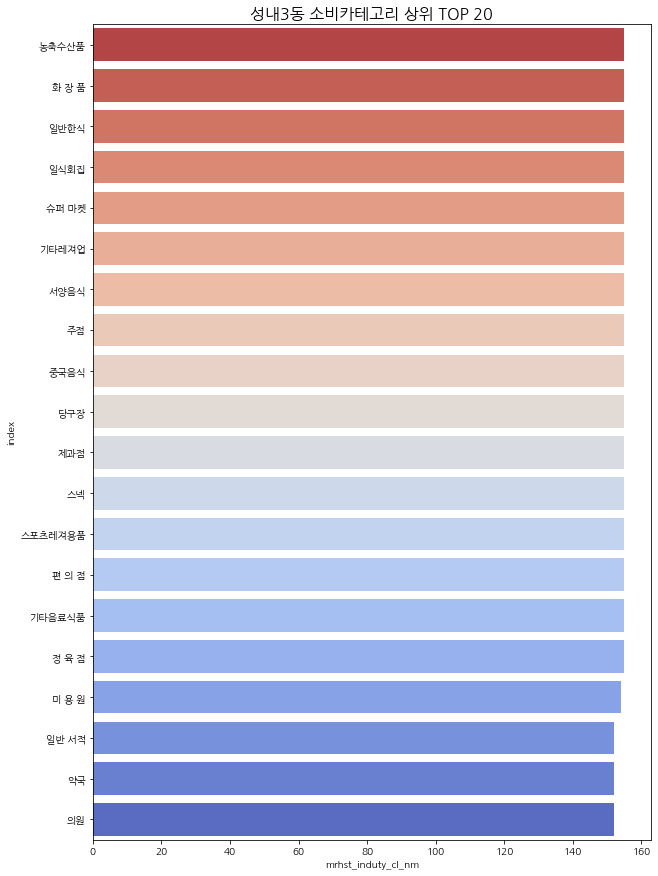

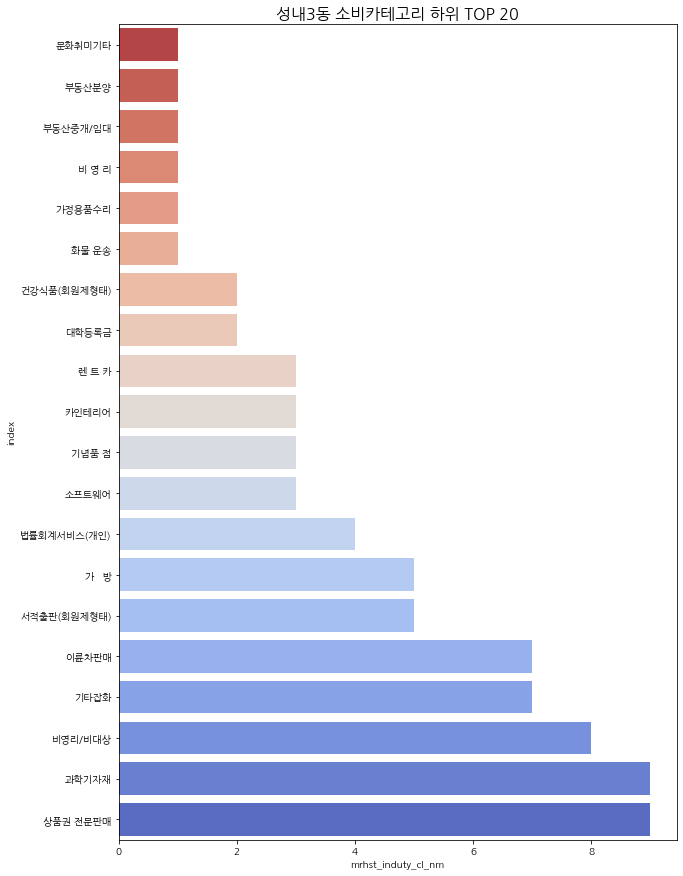

In [141]:
plot_consume_patthern('성내3동')

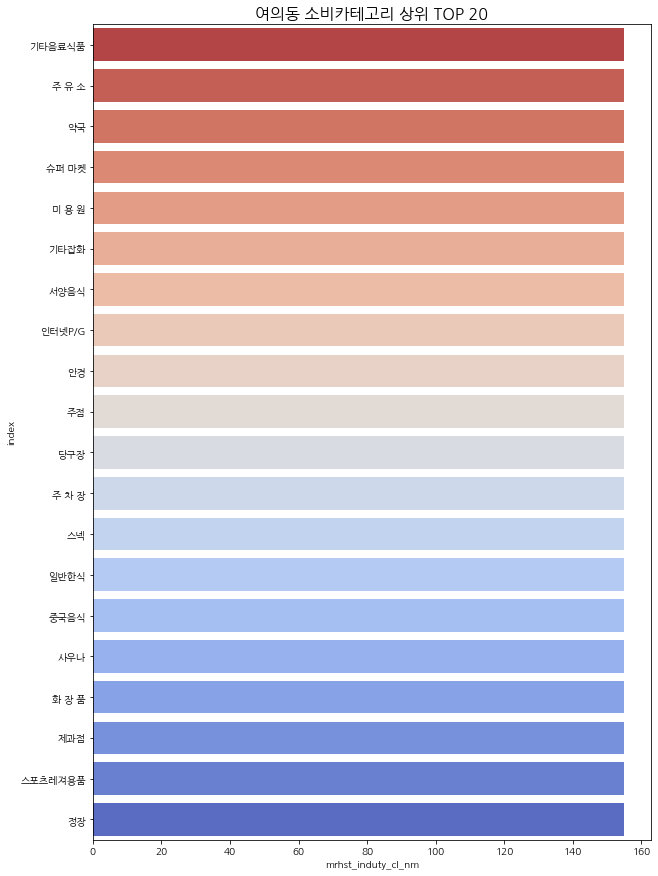

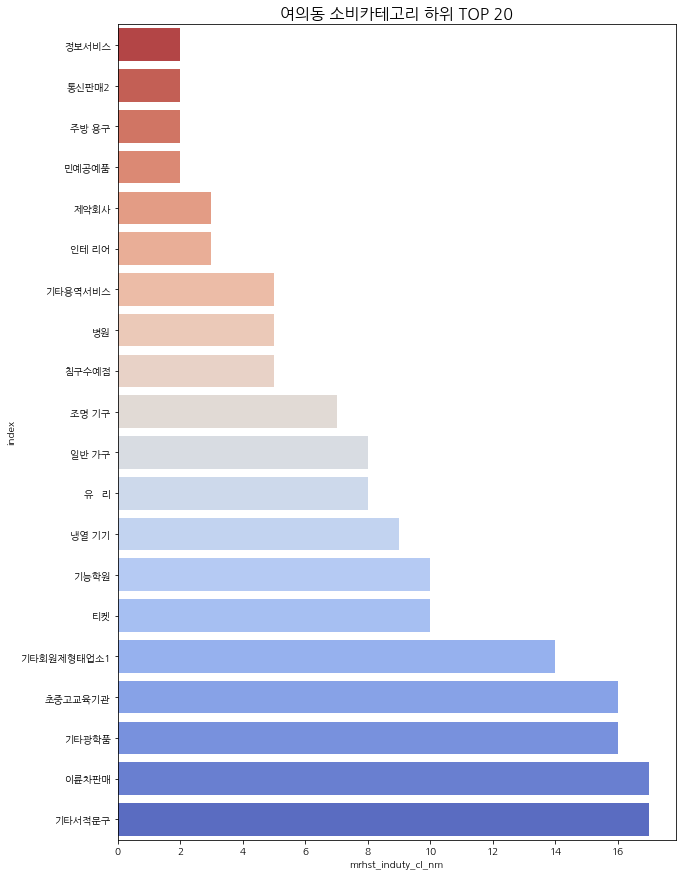

In [148]:
plot_consume_patthern('여의동')

In [82]:
os.listdir(os.path.join(destination,'KT_data_20200717', 'COVID_19'))

['Case.csv',
 'PatientInfo_20200717.csv',
 'Policy.csv',
 'Region.csv',
 'Time.csv',
 'TimeAge.csv',
 'TimeGender.csv',
 'TimeProvince.csv']